# Distributions of features selected with RFE

In [2]:
# default_exp normalization

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
%matplotlib inline

In [5]:
# %load ../common.py
# export

import pandas
import os
import numpy
import seaborn
import logging
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib
from importlib import reload
from ehv import core
from pathlib import Path
import uuid
import re
import scipy

from pandas.api.types import CategoricalDtype

import pyarrow.parquet as pq

from ehv import core

plt.rcParams['figure.facecolor'] = 'white'

numpy.random.seed(42)

In [6]:
from ehv.core import plot_gate_zarr
import scipy.stats

## Data import

In [7]:
data_dir = Path(os.environ["VSC_DATA_VO_USER"]) / "datasets/weizmann/EhV/v2/results/scip/202202071958/"

In [10]:
df = pq.read_table(data_dir / "features.parquet").to_pandas()
cat_type = CategoricalDtype(categories=sorted(df["meta_group"].astype(int).unique()), ordered=True)
df["meta_group"] = df["meta_group"].astype(int).astype(cat_type)
df["meta_replicate"] = df["meta_replicate"].astype(int)
df = df.set_index(["meta_type", "meta_object_number", "meta_replicate", "meta_suffix", "meta_group"])
df = df[numpy.load(data_dir / "indices/columns.npy", allow_pickle=True)]
df = df.loc[numpy.load(data_dir / "indices/iso.npy", allow_pickle=True)]
df = df[df["meta_label"] != "unknown"]
df["meta_label"] = pandas.Categorical(df["meta_label"], categories=["mcp-_psba+", "mcp+_psba+", "mcp+_psba-", "mcp-_psba-"], ordered=True)
df.shape

(104824, 914)

In [13]:
# df = df.loc[numpy.load(data_dir / "umap_cells.npy", allow_pickle=True)]

In [11]:
# todrop = ['feat_combined_mean_BF1', 'feat_mean_BF1',
#        'feat_combined_edge_upper_quartile_BF1',
#        'feat_combined_median_BF1', 'feat_combined_edge_median_BF1',
#        'feat_combined_edge_lower_quartile_BF1',
#        'feat_combined_lower_quartile_BF1', 'feat_edge_median_BF1']
todrop = []

In [12]:
with open(data_dir / "rfe/xgb_features.txt", "r") as fh:
    selected = [col[len("scip_"):] for col in fh.read().split(",") if col[len("scip_"):] not in todrop]

In [13]:
fill_df = df[selected].fillna(0)

In [14]:
# export

def entropy(x):
        density, _ = numpy.histogram(x, density=True)
        return scipy.stats.entropy(density)
    
def minmax(df):
    return pandas.DataFrame(
        data=(df - df.min()) / (df.max() - df.min()),
        columns = df.columns,
        index = df.index
    ) 

def robust(df):
    loc = df.median()
    mad = df.mad()
    
    return (df - loc) / mad


def qq(df, probs):
    q = df.quantile(probs)
    return pandas.DataFrame(
        data=(df - q.loc[probs[0]]) / (q.loc[probs[1]] - q.loc[probs[0]]),
        columns = df.columns,
        index = df.index
    ) 

In [15]:
# export
def dists(df):
    ent = df.apply(entropy, raw=True).sort_values()
    
    fig, ax = plt.subplots(figsize=(10, 20))
    seaborn.stripplot(
        data=pandas.melt(df.sample(n=10000), 
        value_vars=df.columns), y="variable", x="value",
        order=ent.index,
        ax=ax, s=1, alpha=.5
    )
    
    return ent

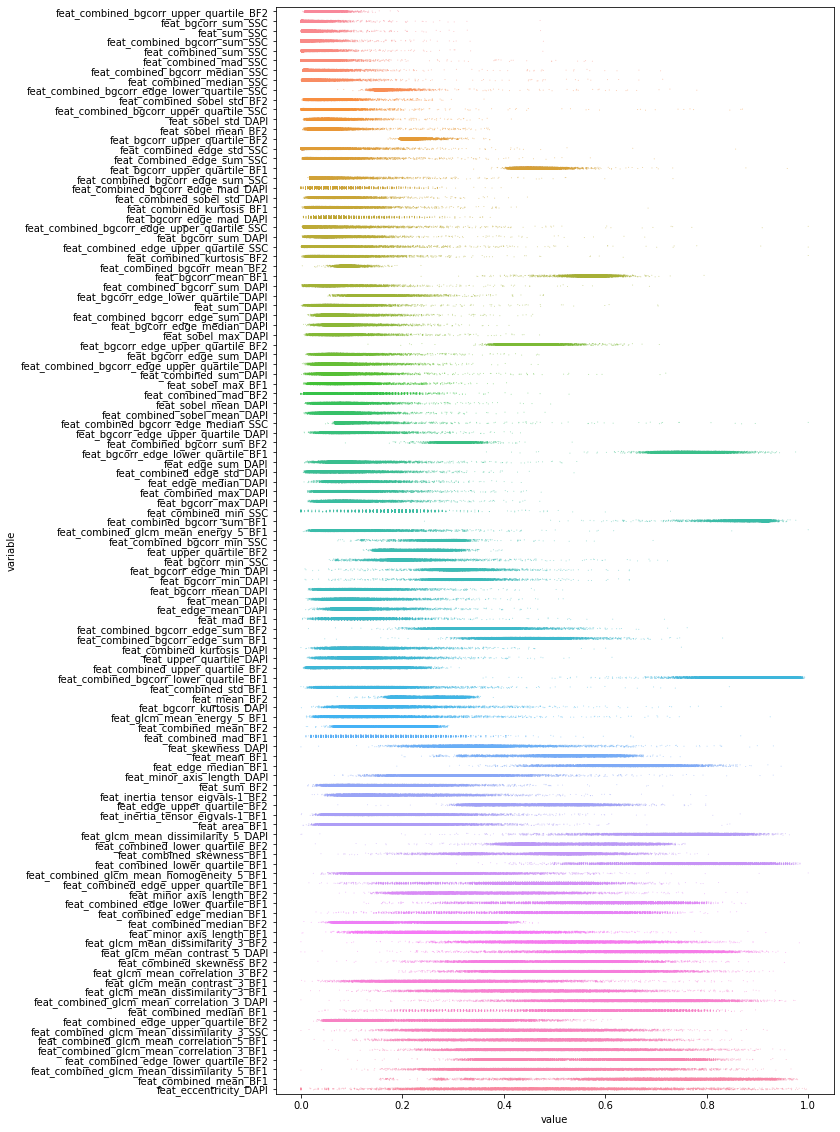

In [12]:
minmax_df = minmax(fill_df)
mm_ent = dists(minmax_df)

In [13]:
mm_ent.sum()

93.0146669974437

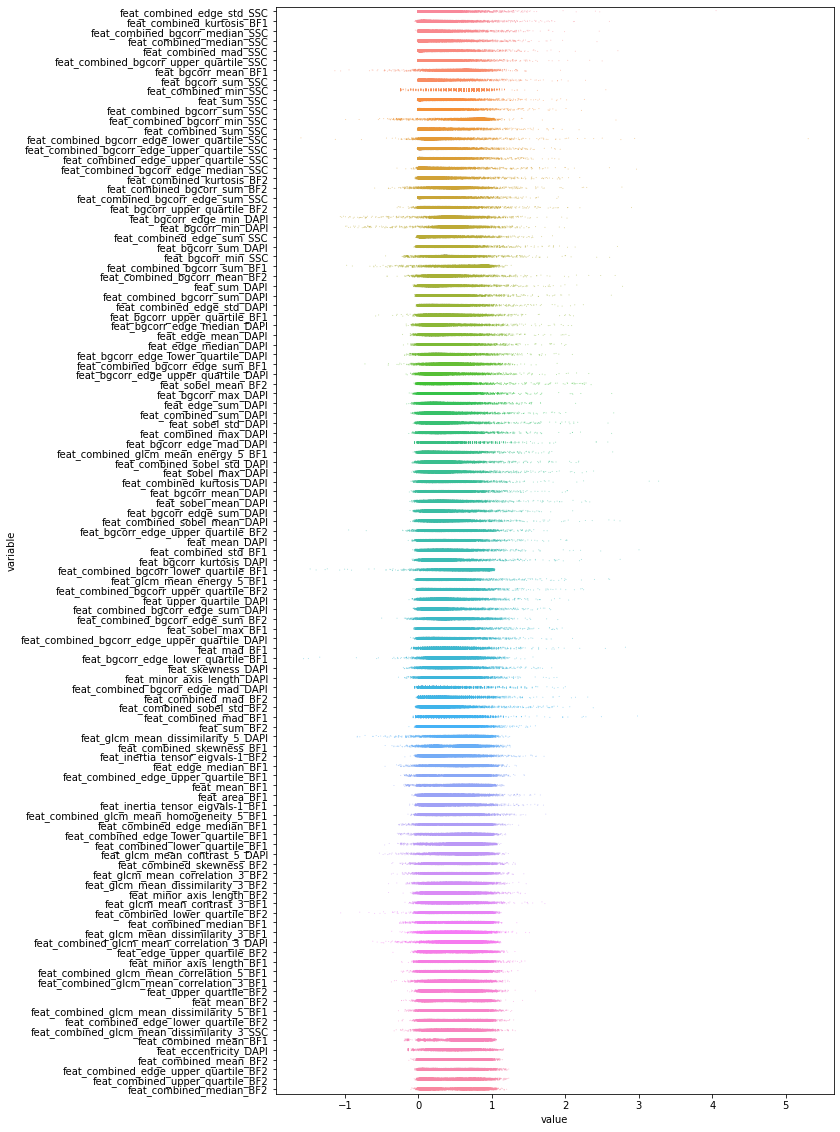

In [29]:
qq_df = qq(fill_df, (0.01, 0.99))
qq_ent = dists(qq_df)

In [17]:
qq_ent.sum()

120.29221323639223

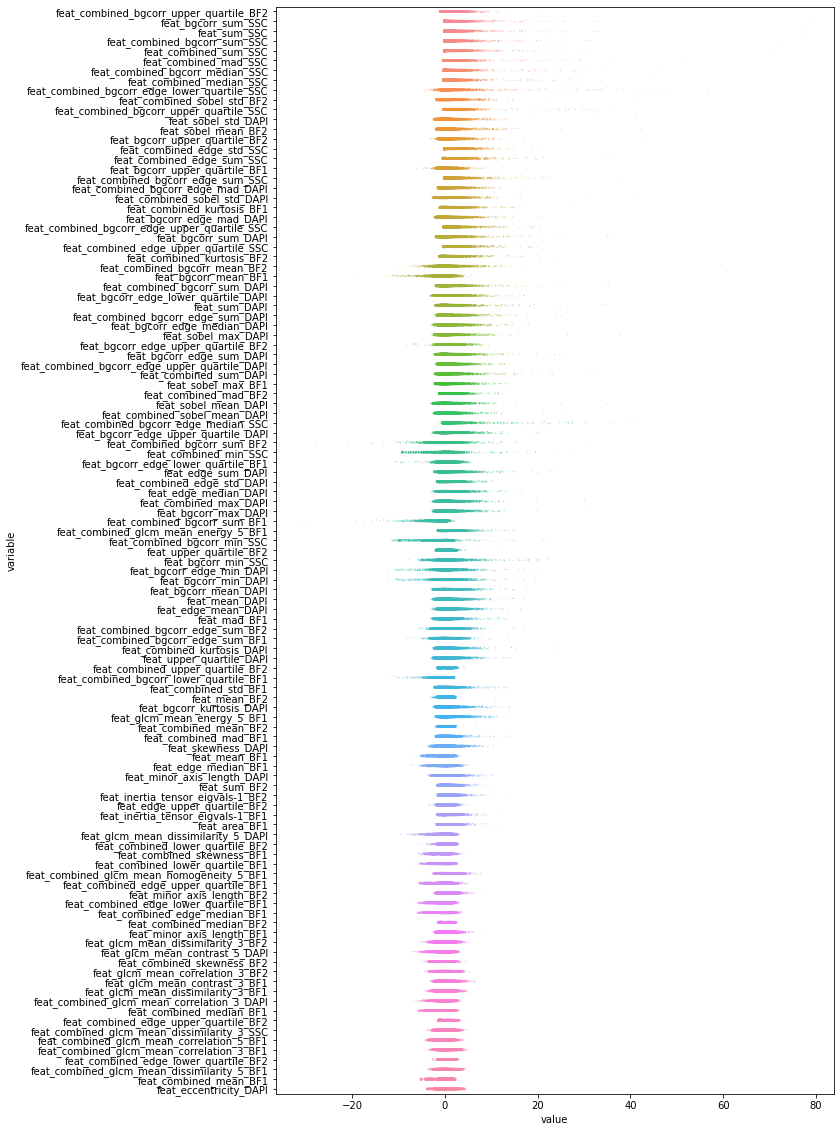

In [16]:
robust_df = robust(fill_df)
rob_ent = dists(robust_df)

In [17]:
rob_ent.sum()

92.9063212137089

# Iso forest

In [18]:
from sklearn.ensemble import IsolationForest

In [30]:
iso = IsolationForest(n_estimators=100, random_state=0, n_jobs=10, contamination=0.01)
iso.fit(
    fill_df
#     .clip(lower=numpy.finfo('float32').min, upper=numpy.finfo('float32').max)  # iso requires everything to fit in float32
)

/data/gent/420/vsc42015/python_lib_doduo/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.01, n_jobs=10, random_state=0)

In [31]:
pred = iso.predict(
    fill_df
)

In [32]:
numpy.unique(pred, return_counts=True)

(array([-1,  1]), array([  1049, 103775]))

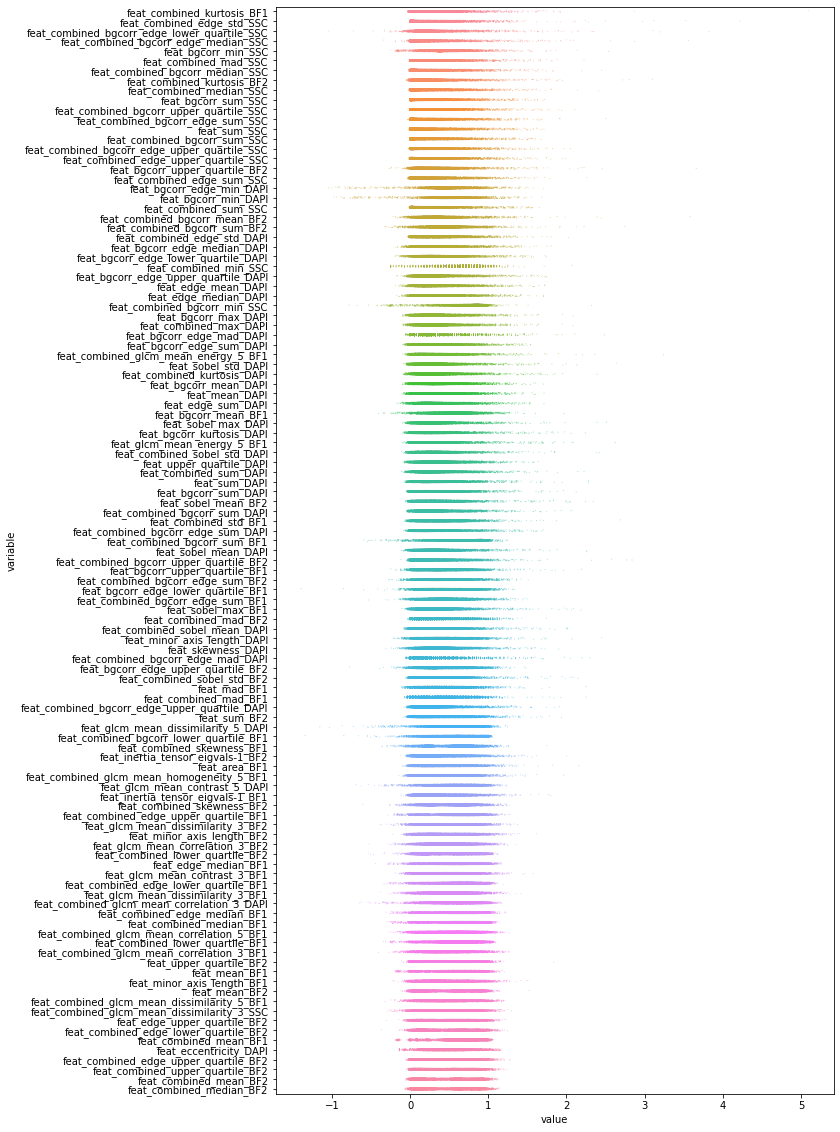

In [33]:
iso_df = qq(fill_df[pred == 1], (0.01, 0.99))
iso_ent = dists(iso_df)

In [34]:
iso_ent.sum()

126.97133369414044

<AxesSubplot:xlabel='value', ylabel='hue'>

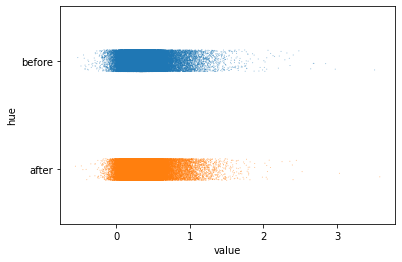

In [35]:
tmp_df = pandas.concat([qq_df, iso_df])
tmp_df["hue"] = ["before"] * len(qq_df) + ["after"] * len(iso_df)

seaborn.stripplot(data=tmp_df.melt(id_vars=["hue"], value_vars=["feat_combined_bgcorr_mean_BF2"]), y="hue", x="value", s=1, alpha=.5)

# Export

In [37]:
numpy.save(data_dir / "indices/iso.npy", iso_df.index)